# TensorFlow Data

Some code cells will be marked with 
```
##########################
######## To Do ###########
##########################
```

This indicates that you are being asked to write a piece of code to complete the notebook.

We need to pip install `tensorflow_addons` which has useful image transformation functions that are compatible with the tensorflow backend.

In [1]:
!pip install tensorflow-addons

In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Any machine learning model is composed of two primary components: model design and training data. While model design and architecture receive significant attention, any model is only as good as the data which it was trained on. We'll discuss how to prepare labeled training data in more detail later. Here we will focus on the most efficient way to wrangle your training data and feed it into a model. TensorFlow models expect to receive data wrapped in an iterator, such that if you call `next(data)` the output is a single data point and its corresponding label.

## Image Datasets

TensorFlow has introduced the `tf.data` API to serve as an end-to-end pipeline for handling data in the context of machine learning. The core of the `tf.data` API is the `tf.data.Dataset` object. We will download the MNIST dataset to use as an example of image data for this tutorial.

In [3]:
train, test = tf.keras.datasets.mnist.load_data()

In [4]:
X, y = train
X.shape, y.shape

((60000, 28, 28), (60000,))

Text(0.5, 1.0, '0')

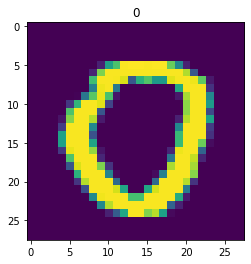

In [5]:
i = np.random.randint(X.shape[0])
fig,ax = plt.subplots()
ax.imshow(X[i])
ax.set_title(y[i])

### Extract
This step addresses the task of reading your dataset and passing it to the Dataset object. There are six different input methods available which are detailed in the [docs](https://www.tensorflow.org/guide/data#reading_input_data). When your dataset can be fully loaded into memory, it can be converted to a tensor and passed directly to the object.

In [6]:
dataset = tf.data.Dataset.from_tensor_slices((X,y))
dataset

<TensorSliceDataset shapes: ((28, 28), ()), types: (tf.uint8, tf.uint8)>

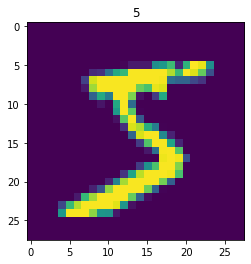

In [7]:
for im,label in dataset.take(1):
    fig,ax = plt.subplots()
    ax.imshow(im)
    ax.set_title(label.numpy())

### Transform
At this stage we can perform any transformations to our data prior to training. This can be as simple as shuffling the dataset prior to retrieving batches or applying random rotations for data augmentation.

#### Shuffle

The first step prior to passing data to a model for training is to shuffle the data such that the order in which the model receives the data is random. The function `dataset.shuffle` requires the arguement `buffer_size` which determines how many elements in the dataset are considered during random selection of each point. For perfect shuffling, `buffer_size` should be the greater than or equal to the size of the dataset. However, this carries a significant memory burden so typiclly `buffer_size` is a fraction of the dataset size. 

In [8]:
dataset = dataset.shuffle(5000,seed=123,reshuffle_each_iteration=True)

#### Augment
Finally, we augment the dataset by performing random transformations to each batch of samples. In order to to this, we revisit the transformation matrices discussed previously. When we initially discussed transformations, we used 2x2 matrices to rotate, reflect, etc a 2D image. For dataset augmentation, we also want to translate the image such that it is shifted in 2D space away from its original center point. In order to do this, we will use a 3x3 matrix and consider each point $P(x,y) = \begin{bmatrix}x&y&1\end{bmatrix}$.

In order to translate point $P(x,y)$ by $(\delta x, \delta y)$, we multiply P by the translation matrix
$$\begin{bmatrix}x & y & 1\end{bmatrix} \times
\begin{bmatrix}
    1 & 0 & 0\\
    0 & 1 & 0\\
    \delta x & \delta y & 1
\end{bmatrix}
=
\begin{bmatrix}x+\delta x & y+\delta y & 1\end{bmatrix}
$$

In order to apply random transformations to the dataset, we can use the `dataset.map` function which will apply any python function to each element in the dataset. First we will write a function to calculate a random transformation matrix that scales the data within the limits of a specified zoom range.

In [9]:
def compute_random_zoom(zoom_min, zoom_max):
    # Get random zoom values for x and y
    zx = np.random.uniform(low=zoom_min, high=zoom_max, size=[1])[0]
    zy = np.random.uniform(low=zoom_min, high=zoom_max, size=[1])[0]

    # Build the matrix
    matrix = [[zx,0,0],[0,zy,0],[0,0,1]]
    return np.array(matrix)

m = compute_random_zoom(0.5, 2)
m

array([[0.59692916, 0.        , 0.        ],
       [0.        , 0.54342923, 0.        ],
       [0.        , 0.        , 1.        ]])

To apply the transformation to an image, we will use the tensorflow_addon function `tfa.image.transform`. This function expects the transformation matrix to be a list of length 8. The function assumes that the ninth value in the matrix (corresponding to the bottom right corner) is always 1. Additionally, the function supports various `fill_modes` which sets the value of points that fall outside of the boundaries of the input.

In [10]:
m = m.flatten()[0:8]
m

array([0.59692916, 0.        , 0.        , 0.        , 0.54342923,
       0.        , 0.        , 0.        ])

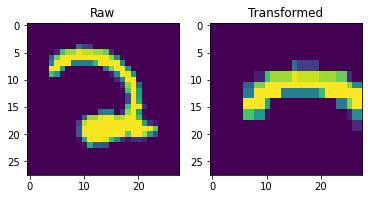

In [11]:
for im,label in dataset.take(1):
    fig,ax = plt.subplots(1,2)
    ax[0].imshow(im)
    ax[0].set_title('Raw')
    ax[1].set_title('Transformed')

    imt = tfa.image.transform(im, m, fill_mode='constant', fill_value=0)
    ax[1].imshow(imt)

We are now ready to write an augmentation function that can be fed into `dataset.map`. The inputs for our new function should match the output of `dataset.take(1)` which in this case is a tuple with an X and y value.

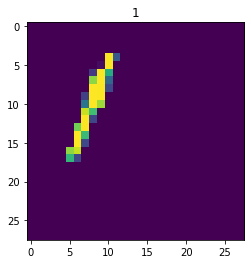

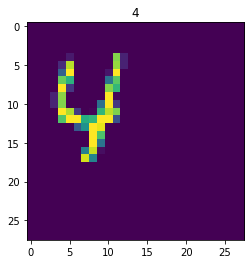

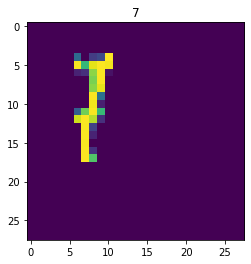

In [12]:
def augment(*args):
    im = args[0]
    label = args[1]

    m = compute_random_zoom(0.5,2)
    m = m.flatten()[0:8]

    imt = tfa.image.transform(im, m, fill_mode='constant', fill_value=0)

    return imt,label

aug_dataset = dataset.map(augment)

for im,label in aug_dataset.take(3):
    fig,ax = plt.subplots()
    ax.imshow(im)
    ax.set_title(label.numpy())

Next, the dataset is broken into batches for model training. The batch size determines how many datapoints are fed through a model before the model is updated. 

```python
dataset = dataset.batch(20)
```

In this examples we have applied each transformation to the dataset sequentially, but practically it's most convenient to apply them in a single line as shown below.

```python
dataset.shuffle(5000,seed=123,reshuffle_each_iteration=True).map(augment).batch(20)
```

## Exercise - Image Augmentation
Try expanding the `augment` function to include at least one additional transformation such as rotation. Remember that you use the dot product of two matrices to combine two transformations into one.

In [13]:
##########################
######## To Do ###########
##########################

# def augment(*args):
#     im = args[0]
#     label = args[1]

#     # Add your transformations here

#     return imt,label

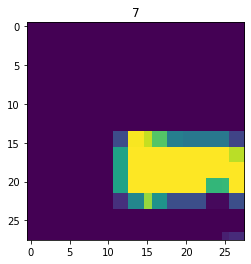

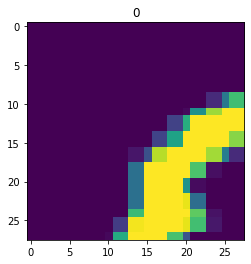

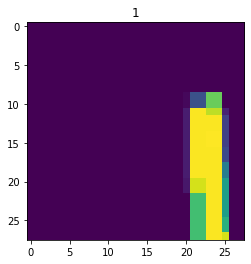

In [14]:
def compute_random_rot(rotrange):
    theta = np.random.uniform(low=rotrange[0], high=rotrange[1], size=[1])[0]

    # Build matrix
    m = np.array([[np.cos(theta),-np.sin(theta),0],
                  [np.sin(theta),np.cos(theta),0],
                  [0,0,1]])
    
    return m

def augment(*args):
    im = args[0]
    label = args[1]

    mz = compute_random_zoom(0.5,2)
    mr = compute_random_rot([-np.pi,np.pi])

    M = np.dot(mz,mr)
    M = m.flatten()[0:8]

    imt = tfa.image.transform(im, m, fill_mode='constant', fill_value=0)

    return imt,label

aug_dataset = dataset.map(augment)

for im,label in aug_dataset.take(3):
    fig,ax = plt.subplots()
    ax.imshow(im)
    ax.set_title(label.numpy())

## Sequence Datasets

We can also use `tf.data` to prepare sequencing data for training. We will use a dataset published as part of the DREAM5 challenge and included as part of the supplement in Alphani et al. 2015.

Alipanahi, B., Delong, A., Weirauch, M.T., and Frey, B.J. (2015). Predicting the sequence specificities of DNA- and RNA-binding proteins by deep learning. Nature Biotechnology 33, 831–838.

For more information on the 2013 DREAM5 Motif Recognition Challenge protocols and evaluation,
please refer to Weirauch et al., 2013 (Nature Biotechnology, doi:10.1038/nbt.2486)

We'll start by loading ChipSeq data for a single transcription factor.

In [15]:
csfile = 'https://storage.googleapis.com/datasets-spring2021/dream5/chipseq/TF_23_CHIP_100_full_genomic.seq'
df = pd.read_csv(csfile,delimiter='\t',header=None)
df

,0,1
0,TGTGCTGAGTGACAGACTCATCAAGGCATGGCACTTCACACCTCTT...,1
1,TTGGCAAGCCTTTGCACTGGCAGTCAAGAACTCAGGAGTGAGAGGG...,1
2,TTCTGGAGGTGTTAAATGGGAAGGTGGCAGGGCCCTGCACACACAC...,1
3,CCCACCAGCAGACAGAGGGACAGCCTTCACAGATGATCCTGTATTT...,1
4,CCAGTTTCTGACAGCCTTGTCACACTAGGTGTTAAGTGAAAAACAT...,1
...,...,...
995,AAAGGACAGGGACCTAGATAAAAAGATTACAGGGAACACTAGAACT...,0
996,TTTAAAGAAATATCCAAATACTTTTCATTATGAAATAGAATTTGAT...,0
997,TCCCCCTTCCCATTCTGTTCATCATGGTAATAGCTGGCCCTGTGTA...,0
998,ATGATCTGAATCAAGATTTACCCAATTTCAATTGAATTCTTTTCTA...,0


We need to check the length of each sequence to see if they are consistent or if we will need to pad/truncate to achieve a consistent length.

In [16]:
df[0].str.len().unique()

array([101])

### One Hot DNA
Since are sequences are all the same length (101 bases), we can continue and look at applying one hot encoding to our data. `scikit-learn` has a useful preprocessing function `OneHotEncoder` that we can use, but we will need to provide our data in an array instead of a pandas dataframe.

In [17]:
##########################
######## To Do ###########
##########################

# Write a function that takes in a dataframe of sequences and labels 
# And returns two arrays, X and y
# X.shape = (number of samples, length of sequence)
# Y.shape = (number of samples, 1)

# def seq_to_array(df):

#     # Add your code here

#     return X,y

In [18]:
def seq_to_array(df):

    # Grab label values and reshape to add last axis
    y = df[1].values.reshape(-1,1)

    # Expand str into a list of individual characters in str
    X = df[0].str.split('').values

    # Current structure of an array of lists, recast as array
    X = np.array(list(X))

    # Drop empty str from first and last column
    X = X[:,1:-1]

    return X,y

In [19]:
Xraw,yraw = seq_to_array(df)
print(Xraw.shape)
print(Xraw[0])
print(yraw.shape)
print(yraw[0])

(1000, 101)
['T' 'G' 'T' 'G' 'C' 'T' 'G' 'A' 'G' 'T' 'G' 'A' 'C' 'A' 'G' 'A' 'C' 'T'
 'C' 'A' 'T' 'C' 'A' 'A' 'G' 'G' 'C' 'A' 'T' 'G' 'G' 'C' 'A' 'C' 'T' 'T'
 'C' 'A' 'C' 'A' 'C' 'C' 'T' 'C' 'T' 'T' 'A' 'C' 'A' 'G' 'A' 'G' 'C' 'A'
 'A' 'A' 'G' 'C' 'C' 'T' 'C' 'G' 'A' 'A' 'A' 'T' 'C' 'A' 'C' 'C' 'C' 'G'
 'G' 'C' 'A' 'A' 'A' 'A' 'T' 'C' 'T' 'C' 'C' 'C' 'T' 'A' 'G' 'T' 'C' 'C'
 'T' 'G' 'C' 'C' 'T' 'C' 'T' 'T' 'G' 'G' 'G']
(1000, 1)
[1]


In [20]:
from sklearn.preprocessing import OneHotEncoder

onehotDNA = OneHotEncoder()

The encoder expects that each column in the dataset is a unique feature set. Since we are dealing with one feature set (ATGC), we need to reshape our data to comply.



In [21]:
Xpre = Xraw.reshape(-1,1)
Xpre.shape

(101000, 1)

In [22]:
onehotDNA.fit(Xpre)
onehotDNA.categories_

[array(['A', 'C', 'G', 'T'], dtype='<U1')]

In [23]:
Xpost = onehotDNA.transform(Xpre).toarray()
print(Xpost.shape)
Xpost

(101000, 4)


array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

In [24]:
out = onehotDNA.fit_transform(Xpre).toarray()

Now each character is one-hot encoded, but we need to reshape the array to restore the proper shape (number of samples, len of sequence, 4).

In [25]:
X = Xpost.reshape(Xraw.shape[0],Xraw.shape[1],4)
X.shape

(1000, 101, 4)

Finally, we can compile all of the steps needed to get from the `.seq` file to the final form of the data into a single preprocessing function that returns a tensorflow dataset object.

In [26]:
def load_seq(fpath):
    df = pd.read_csv(csfile,delimiter='\t',header=None)
    Xraw,yraw = seq_to_array(df)
    
    onehotDNA = OneHotEncoder()

    # We can fit and transform in a single step now
    X = onehotDNA.fit_transform(Xraw.reshape(-1,1)).toarray()
    # Reshape to pull out individual samples
    X = X.reshape(Xraw.shape[0],Xraw.shape[1],4)

    dataset = tf.data.Dataset.from_tensor_slices((X,yraw))

    return dataset

In [27]:
dataset = load_seq(csfile)

In [28]:
for seq,label in dataset.take(1):
    print(label,'\t',seq)

tf.Tensor([1], shape=(1,), dtype=int64) 	 tf.Tensor(
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [

We are now ready to shuffle and batch the dataset for training. In a future notebook, we'll spend more time thinking about appropriate augmentation strategies for sequence data.